In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import umap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef

In [14]:
# read data from files
# features were stored in the file "X without header.txt"
# identities were stored in the file "Y.txt"

dataX = np.loadtxt("X without header.txt", delimiter=',')
dataY = np.loadtxt("Y.txt",delimiter=',')

#normalization of dataX
dataX = preprocessing.StandardScaler().fit(dataX).transform(dataX.astype(float))

dataY = dataY.astype(int)

#split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataX,dataY,test_size=0.25, random_state=2)

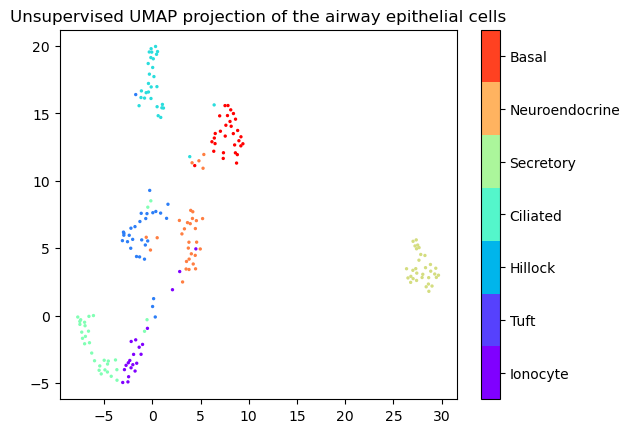

In [15]:
###############################################################
######################       UMAP      ########################
###############################################################

embedding = umap.UMAP(random_state=42,spread=3,min_dist=0.1).fit_transform(dataX)
classes = ['Ionocyte', 'Tuft', 'Hillock', 'Ciliated', 'Secretory', 'Neuroendocrine', 'Basal']
plt.scatter(*embedding.T, s=2, c=dataY,cmap='rainbow')
cbar = plt.colorbar(boundaries=np.arange(8))
cbar.set_ticks(np.arange(7)+0.5)
cbar.set_ticklabels(classes)
plt.title('Unsupervised UMAP projection of the airway epithelial cells', fontsize=12)
plt.savefig("umap random_state42_spread_3_min_dist_0.1.pdf")

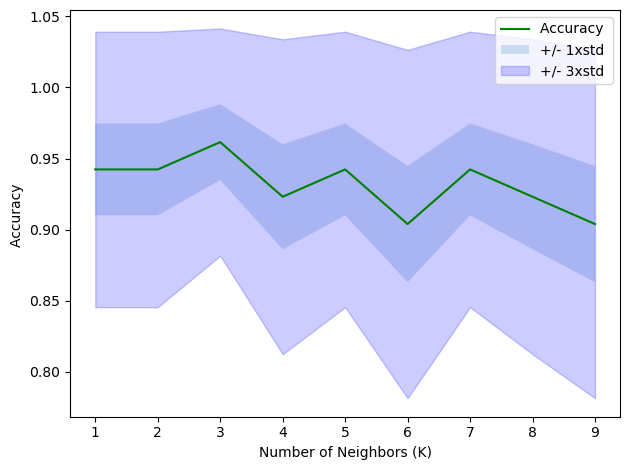

In [16]:
###############################################################
########################## KNN ################################
###############################################################

# Testing k from 1 to 9
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):    
    #Train Model and Predict  
    model_kNNs = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=model_kNNs.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.20)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.20,color="blue")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()

Train set Accuracy:  0.9415584415584416
Test set Accuracy:  0.9615384615384616
Matthews correlation coefficient:  0.9551206417369813


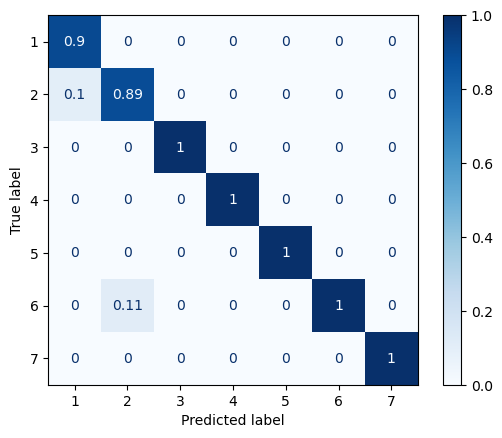

In [17]:
# k =3 was picked to test show model accuracy and confusion matrix
k = 3
#Train Model and Predict  
model_kNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = model_kNN.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("kNN.pdf")
print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_kNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))


Train set Accuracy:  0.9805194805194806
Test set Accuracy:  0.9615384615384616
Matthews correlation coefficient:  0.9551017135067327


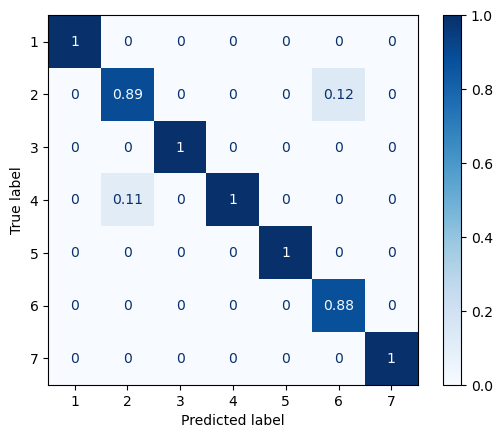

In [18]:
###############################################################
############### Multinomial logistic regression ###############
###############################################################

from sklearn.linear_model import LogisticRegression

model_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=1)
model_reg.fit(X_train, y_train)
yhat=model_reg.predict(X_test)
yhat_prob=model_reg.predict_proba(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("regression.pdf")

print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_reg.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))





D:\Anaconda\envs\sep2022\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train set Accuracy:  1.0
Test set Accuracy:  0.9230769230769231
Matthews correlation coefficient:  0.9107919930374239
Feature importance calculated by xgb model:  [0.10378385 0.11777239 0.06288733 0.1831634  0.08719636 0.01330981
 0.07660603 0.02179408 0.13309267 0.06920172 0.02426622 0.10692611]


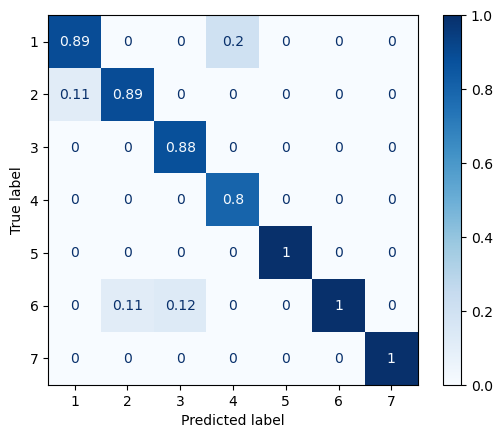

In [19]:
###############################################################
####################       xgboost      #######################
###############################################################
import xgboost as xgb

model_xgb = xgb.XGBClassifier(objective="multi:softprob", random_state=42, reg_lambda=1)
model_xgb.fit(X_train, y_train)
yhat = model_xgb.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("xgboost.pdf")

print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_xgb.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))

################################################################
# Calculating the importance of each feature using xgb package #
################################################################

print("Feature importance calculated by xgb model: ", model_xgb.feature_importances_)


In [20]:
###############################################################
######### Run the models without autoflourescence #############
###############################################################


# read data from files
# features without autoflouresence were stored in the file "X without header no autofluorescence.txt"
# identities were stored in the file "Y.txt"

dataX = np.loadtxt("X without header no autofluorescence.txt", delimiter=',')
dataY = np.loadtxt("Y.txt",delimiter=',')

#normalization of dataX
dataX = preprocessing.StandardScaler().fit(dataX).transform(dataX.astype(float))

dataY = dataY.astype(int)

#split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataX,dataY,test_size=0.25, random_state=2)

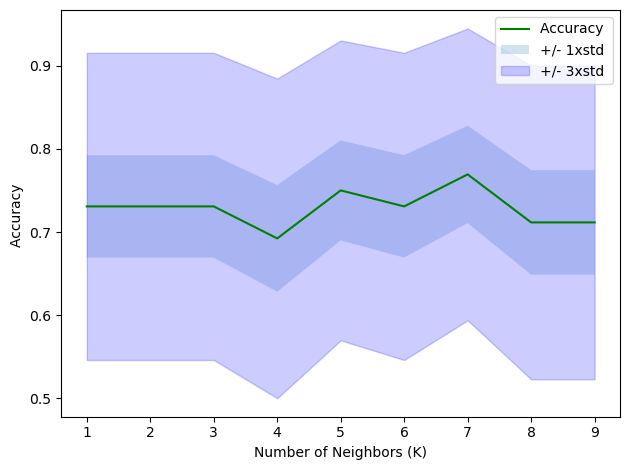

In [21]:
###############################################################
################# KNN without autoflourescence#################
###############################################################

# Testing k from 1 to 9
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):    
    #Train Model and Predict  
    model_kNNs = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=model_kNNs.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.20)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.20,color="blue")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()

Train set Accuracy:  0.8116883116883117
Test set Accuracy:  0.7692307692307693
Matthews correlation coefficient:  0.7376205748955982


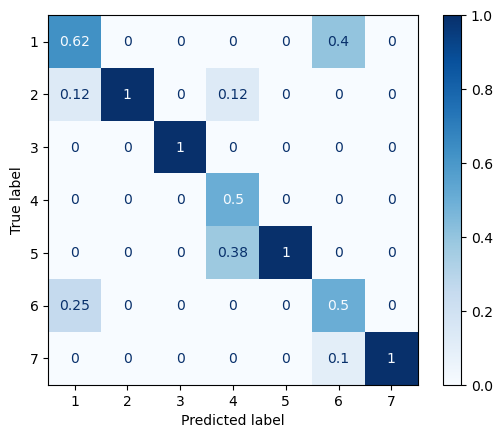

In [22]:
# k =7 was picked to test show model accuracy and confusion matrix
k = 7
#Train Model and Predict  
model_kNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = model_kNN.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("kNN without autoflourescence.pdf")
print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_kNN.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))

Train set Accuracy:  0.7727272727272727
Test set Accuracy:  0.7115384615384616
Matthews correlation coefficient:  0.6697299474833109


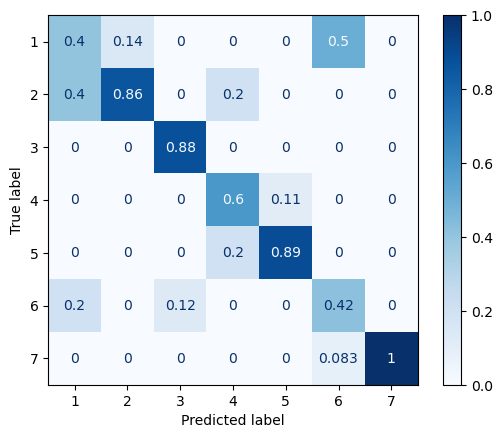

In [23]:
################################################################
### Multinomial logistic regression without autoflourescence ###
################################################################

from sklearn.linear_model import LogisticRegression

model_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=1)
model_reg.fit(X_train, y_train)
yhat=model_reg.predict(X_test)
yhat_prob=model_reg.predict_proba(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("regression without autoflourescence.pdf")

print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_reg.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))



D:\Anaconda\envs\sep2022\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train set Accuracy:  1.0
Test set Accuracy:  0.8076923076923077
Matthews correlation coefficient:  0.7797098091687673
Feature importance calculated by xgb model:  [0.375495   0.1480387  0.06251863 0.24803445 0.05337817 0.11253505]


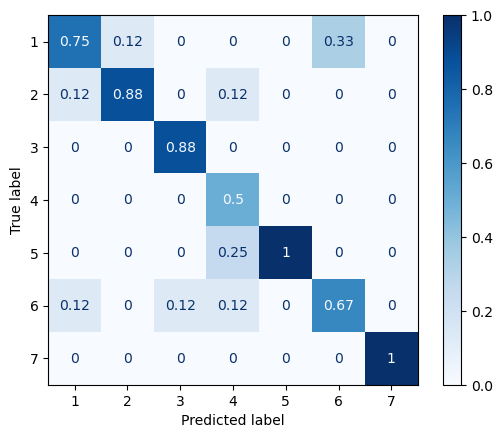

In [24]:
###############################################################
####################       xgboost      #######################
###############################################################
import xgboost as xgb

model_xgb = xgb.XGBClassifier(objective="multi:softprob", random_state=42, reg_lambda=1)
model_xgb.fit(X_train, y_train)
yhat = model_xgb.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_test, yhat,cmap=plt.cm.Blues,normalize='pred')
plt.savefig("xgboost without autoflourescence.pdf")

print("Train set Accuracy: ", metrics.accuracy_score(y_train, model_xgb.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, yhat))


################################################################
# Calculating the importance of each feature using xgb package #
################################################################

print("Feature importance calculated by xgb model: ", model_xgb.feature_importances_)